In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as T
from data.transform import get_yolo_transform
from data.dataset import YOLOMaskDataset, COCO_CLASSES

from utils.convert import cells_to_boxes, xywh2tlbr
from utils.cleanup import nms_by_class
from utils.display import draw_boxes

%load_ext autoreload
%autoreload 2

In [3]:
scales = [ 13, 26, 52 ]
anchors = [
    [[0.28, 0.22], [0.38, 0.48], [0.9, 0.78]],
    [[0.07, 0.15], [0.15, 0.11], [0.14, 0.29]],
    [[0.02, 0.03], [0.04, 0.07], [0.08, 0.06]],
]

In [4]:
transform = get_yolo_transform(416, mode='train')

In [5]:
dataset = YOLOMaskDataset(csv_file="../download/COCO/test.csv",
                         img_dir="../download/COCO/images/",
                         mask_dir="../download/COCO/masks/",
                         anchors=anchors,
                         scales=scales,
                         n_classes=80,
                         transform=transform)

In [6]:
img, masks, targets = dataset[0]

In [7]:
masks.shape

torch.Size([5, 416, 416])

In [8]:
inverse = T.ToPILImage()

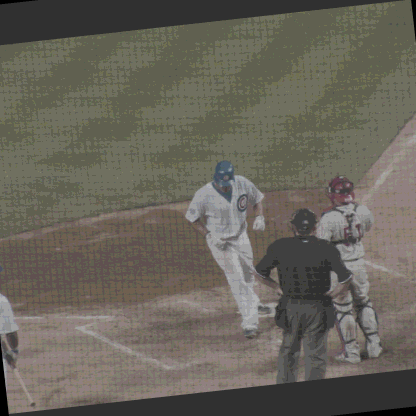

In [9]:
inverse(img)

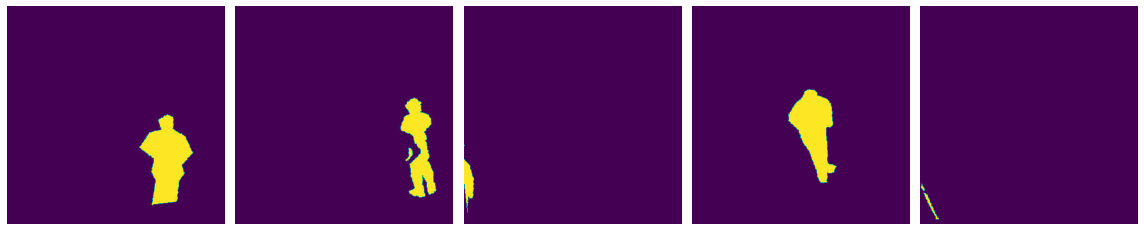

In [10]:
ncols = len(masks)

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))

if ncols == 1:
    axes.imshow(masks[0])
    axes.set_axis_off()
else:
    for idx, mask in enumerate(masks):
        axes[idx].imshow(mask)
        axes[idx].set_axis_off()

plt.tight_layout()

In [11]:
bboxes = []
for scale, target in zip(scales, targets):
    # Convert bounding boxes to normalized format (xywh)
    cell_boxes = cells_to_boxes(target.unsqueeze(0), scale=scale)
    obj_mask = cell_boxes[..., 4] == 1.
    boxes = cell_boxes[obj_mask]
    bboxes.append(boxes)
    
# Collect sample
bboxes = torch.cat(bboxes, dim=0)

In [12]:
nms_boxes = []
# Perform NMS on each class
for c, name in enumerate(COCO_CLASSES):
    boxes = nms_by_class(bboxes, target=c, iou_threshold=0.9)
    nms_boxes.extend(boxes)
    
print(torch.tensor(np.array(nms_boxes)))

tensor([[-2.9812e-03,  6.1059e-01,  6.0673e-02,  9.9037e-01,  1.0000e+00,
          0.0000e+00,  2.0000e+00],
        [ 4.2272e-01,  3.6752e-01,  6.7343e-01,  8.1998e-01,  1.0000e+00,
          0.0000e+00,  3.0000e+00],
        [ 7.4002e-01,  4.0946e-01,  9.3305e-01,  8.7900e-01,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 5.8626e-01,  4.8257e-01,  8.7048e-01,  9.1166e-01,  1.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3952e-03,  8.0402e-01,  8.3126e-02,  9.7964e-01,  1.0000e+00,
          3.4000e+01,  4.0000e+00]], dtype=torch.float64)


tensor([ 4183.5903, 19631.0254, 15684.8018, 21105.1777,  2568.7847])


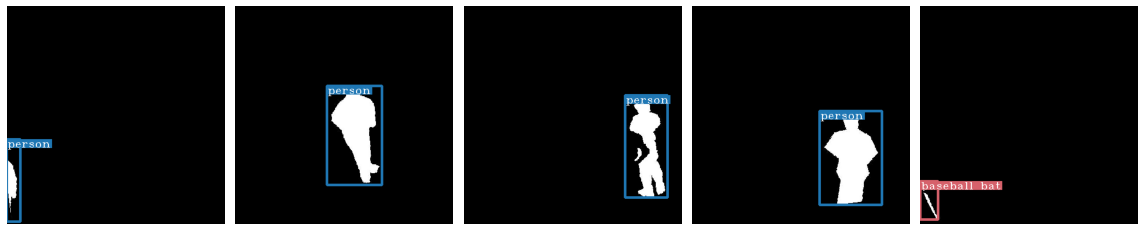

In [13]:
ncols = len(masks)

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))
img_width, img_height = masks[0].shape[1], masks[0].shape[0]

bboxes = torch.tensor(nms_boxes)
bboxes[..., 0] *= img_width
bboxes[..., 1] *= img_height
bboxes[..., 2] *= img_width
bboxes[..., 3] *= img_height
print((bboxes[..., 2]-bboxes[...,0])*(bboxes[..., 3]-bboxes[...,1]))

if ncols == 1:
    canvas = np.uint8(np.stack((masks[0],)*3, axis=-1)*255)
    draw_boxes(canvas, bboxes[0].unsqueeze(0).tolist(), COCO_CLASSES)
    axes.imshow(canvas)
    axes.set_axis_off()
else:
    for idx, box in enumerate(bboxes):
        mask_id = int(box[-1])
        mask = masks[mask_id]
        canvas = np.uint8(np.stack((mask,)*3, axis=-1)*255)
        draw_boxes(canvas, box.unsqueeze(0).tolist(), COCO_CLASSES)
        axes[idx].imshow(canvas)
        axes[idx].set_axis_off()

plt.tight_layout()